In [1]:
import os
import glob
import sys

from shutil import copyfile
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [12]:
base_path = '../experiments/'
model = 'resnet18'

MODELS = {
    'resnet18': 'resnet18',
    'efficientnet': 'efficientnet',
    'densenet': 'densenet'
}

METHODS = {
    "deconv": "deconv",
    "ig": "ig",
    "saliency": "saliency",
    "gradcam": "gradcam",
    "gradshap": "gradshap",
    "gbp": "gbp",
}

SPLIT_OPTIONS = ["100%", "80%", "60%", "40%", "20%"]

DATASETS = {
    "edible-plants": "edible-plants",
    "food101": "food101",
    "marvel": "marvel",
    "plant-data": "plant-data",
    "stanford-dogs": "stanford-dogs",
}
AUG_TYPES = [
    'rotation',
    'filters'
]
KEYS = {
    'rotation': [
        '# 0-ssim',
        '0-score',
        ['-30-ssim',
        '-30-score'],
        ['-15-ssim',
        '-15-score'],
        ['15-ssim',
        '15-score'],
        ['30-ssim',
        '30-score']
    ],
    'filters': [
        "# none-ssim",
        "none-score",
        ["fx_freaky_details 2,10,1,11,0,32,0-ssim",
        "fx_freaky_details 2,10,1,11,0,32,0-score"],
        ["normalize_local 8,10-ssim",
        "normalize_local 8,10-score"],
        ["fx_boost_chroma 90,0,0-ssim",
        "fx_boost_chroma 90,0,0-score"],
        ["fx_mighty_details 25,1,25,1,11,0-ssim",
        "fx_mighty_details 25,1,25,1,11,0-score"],
        ["sharpen 300-ssim",
        "sharpen 300-score"]
    ]
}

LABEL_MAP = {
    '-30-ssim-ig': 'Integrated Gradinets: -30° rotation',
    '-30-ssim-saliency': 'Saliency: -30° rotation',
    '-30-ssim-gradcam': 'Guided GradCAM: -30° rotation',
    '-30-ssim-gradshap': 'Gradient SHAP: -30° rotation',
    '-30-ssim-gbp': 'Guided Backpropagation: -30° rotation',
    '-30-ssim-deconv': 'Deconvolution: -30° rotation',
    '-15-ssim-ig': 'Integrated Gradinets: -15° rotation',
    '-15-ssim-saliency': 'Saliency: -15° rotation',
    '-15-ssim-gradcam': 'Guided GradCAM: -15° rotation',
    '-15-ssim-gradshap': 'Gradient SHAP: -15° rotation',
    '-15-ssim-gbp': 'Guided Backpropagation: -15° rotation',
    '-15-ssim-deconv': 'Deconvolution: -15° rotation',
    '15-ssim-ig': 'Integrated Gradinets: 15° rotation',
    '15-ssim-saliency': 'Saliency: 15° rotation',
    '15-ssim-gradcam': 'Guided GradCAM: 15° rotation',
    '15-ssim-gradshap': 'Gradient SHAP: 15° rotation',
    '15-ssim-gbp': 'Guided Backpropagation: 15° rotation',
    '15-ssim-deconv': 'Deconvolution: 15° rotation',
    '30-ssim-ig': 'Integrated Gradinets: 30° rotation',
    '30-ssim-saliency': 'Saliency: 30° rotation',
    '30-ssim-gradcam': 'Guided GradCAM: 30° rotation',
    '30-ssim-gradshap': 'Gradient SHAP: 30° rotation',
    '30-ssim-gbp': 'Guided Backpropagation: 30° rotation',
    '30-ssim-deconv': 'Deconvolution: 30° rotation',
    'ig': 'Integrated Gradinets',
    'saliency': 'Saliency',
    'gradcam': 'Guided GradCAM',
    'gradshap': 'Gradient SHAP',
    'gbp': 'Guided Backpropagation',
    'deconv': 'Deconvolution',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-ig': 'Integrated Gradinets: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-saliency': 'Saliency: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gradcam': 'Guided GradCAM: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gradshap': 'Gradient SHAP: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-gbp': 'Guided Backpropagation: Freaky Details',
    'fx_freaky_details 2,10,1,11,0,32,0-ssim-deconv': 'Deconvolution: Freaky Details',
    'normalize_local 8,10-ssim-ig': 'Integrated Gradinets: Local Normalization',
    'normalize_local 8,10-ssim-saliency': 'Saliency: Local Normalization',
    'normalize_local 8,10-ssim-gradcam': 'Guided GradCAM: Local Normalization',
    'normalize_local 8,10-ssim-gradshap': 'Gradient SHAP: Local Normalization',
    'normalize_local 8,10-ssim-gbp': 'Guided Backpropagation: Local Normalization',
    'normalize_local 8,10-ssim-deconv': 'Deconvolution: Local Normalization',
    'fx_boost_chroma 90,0,0-ssim-ig': 'Integrated Gradinets: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-saliency': 'Saliency: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gradcam': 'Guided GradCAM: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gradshap': 'Gradient SHAP: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-gbp': 'Guided Backpropagation: Chroma Boost',
    'fx_boost_chroma 90,0,0-ssim-deconv': 'Deconvolution: Chroma Boost',
    'fx_mighty_details 25,1,25,1,11,0-ssim-ig': 'Integrated Gradinets: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-saliency': 'Saliency: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gradcam': 'Guided GradCAM: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gradshap': 'Gradient SHAP: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-gbp': 'Guided Backpropagation: Mighty Details',
    'fx_mighty_details 25,1,25,1,11,0-ssim-deconv': 'Deconvolution: Mighty Details',
    'sharpen 300-ssim-ig': 'Integrated Gradinets: Sharpen',
    'sharpen 300-ssim-saliency': 'Saliency: Sharpen',
    'sharpen 300-ssim-gradcam': 'Guided GradCAM: Sharpen',
    'sharpen 300-ssim-gradshap': 'Gradient SHAP: Sharpen',
    'sharpen 300-ssim-gbp': 'Guided Backpropagation: Sharpen',
    'sharpen 300-ssim-deconv': 'Deconvolution: Sharpen',
}

threshold = 0.05


fig_size = (30,16)
title_font=32
label_font=28
marker_size=18

plt.rcParams.update({'font.size': 22})

In [13]:

SSIM = {
    'rotation': {},
    'filters': {},
}
SSIM_METHODS = {
    
}
RESULTS = {
    'rotation': {},
    'filters': {},
}

In [14]:
## Extract data from csv files

In [15]:
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    if not method in SSIM[aug_type]:
                        SSIM[aug_type][method] = pd.DataFrame()
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    SSIM[aug_type][method] = SSIM[aug_type][method].append(method_df, ignore_index=True)
            
            
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    if not method in SSIM_METHODS:
                        SSIM_METHODS[method] = pd.DataFrame()
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    SSIM_METHODS[method] = SSIM_METHODS[method].append(method_df, ignore_index=True)
        


In [16]:
print(len(SSIM['rotation']['ig']))

1455


In [17]:
print(len(SSIM_METHODS['ig']))

2910


In [18]:
### Drop values outside threshold

In [19]:
for aug_type in AUG_TYPES:
    for method in METHODS.keys():
        for aug_method in KEYS[aug_type][2:]:
            SSIM[aug_type][method][aug_method[0]] = SSIM[aug_type][method][aug_method[0]][(SSIM[aug_type][method][aug_method[1]] - SSIM[aug_type][method][KEYS[aug_type][1]]).abs() < threshold]
            
for method in METHODS.keys():
    for aug_method in KEYS[AUG_TYPES[0]][2:]:
        SSIM_METHODS[method][aug_method[0]] = SSIM_METHODS[method][aug_method[0]][(SSIM_METHODS[method][aug_method[1]] - SSIM_METHODS[method][KEYS[AUG_TYPES[0]][1]]).abs() < threshold]
    for aug_method in KEYS[AUG_TYPES[1]][2:]:
        SSIM_METHODS[method][aug_method[0]] = SSIM_METHODS[method][aug_method[0]][(SSIM_METHODS[method][aug_method[1]] - SSIM_METHODS[method][KEYS[AUG_TYPES[1]][1]]).abs() < threshold]

In [20]:
for aug_type in AUG_TYPES:
    for method in METHODS.keys():
        for aug_method in KEYS[aug_type][2:]:
            if not method in RESULTS[aug_type]:
                RESULTS[aug_type][method] = {}
                RESULTS[aug_type][method]['mean'] = SSIM[aug_type][method][
                    [
                        aug_arr[0] for aug_arr in KEYS[aug_type][2:]
                    ]
                ].stack().mean(skipna=True)
                RESULTS[aug_type][method]['std'] = SSIM[aug_type][method][
                    [
                        aug_arr[0] for aug_arr in KEYS[aug_type][2:]
                    ]
                ].stack().std(skipna=True)
                
            if not aug_method[0] in RESULTS[aug_type][method]:
                RESULTS[aug_type][method][aug_method[0]] = { 'mean': 0, 'std': 0 }
                
            RESULTS[aug_type][method][aug_method[0]]['mean'] = SSIM[aug_type][method][aug_method[0]].mean(skipna=True)
            RESULTS[aug_type][method][aug_method[0]]['std'] = SSIM[aug_type][method][aug_method[0]].std(skipna=True)
            
            
            
for method in METHODS.keys():
    if not method in RESULTS:
        RESULTS[method] = {}
        
    RESULTS[method]['mean'] = SSIM_METHODS[method][
        [
            aug_arr[0] for aug_arr in KEYS[AUG_TYPES[0]][2:] + KEYS[AUG_TYPES[1]][2:]
        ]
    ].stack().mean(skipna=True)
    RESULTS[method]['std'] = SSIM_METHODS[method][
        [
            aug_arr[0] for aug_arr in KEYS[AUG_TYPES[0]][2:] + KEYS[AUG_TYPES[1]][2:]
        ]
    ].stack().std(skipna=True)

In [21]:
all_means = []
all_stds = []
all_labels = []

<Figure size 2160x1872 with 0 Axes>

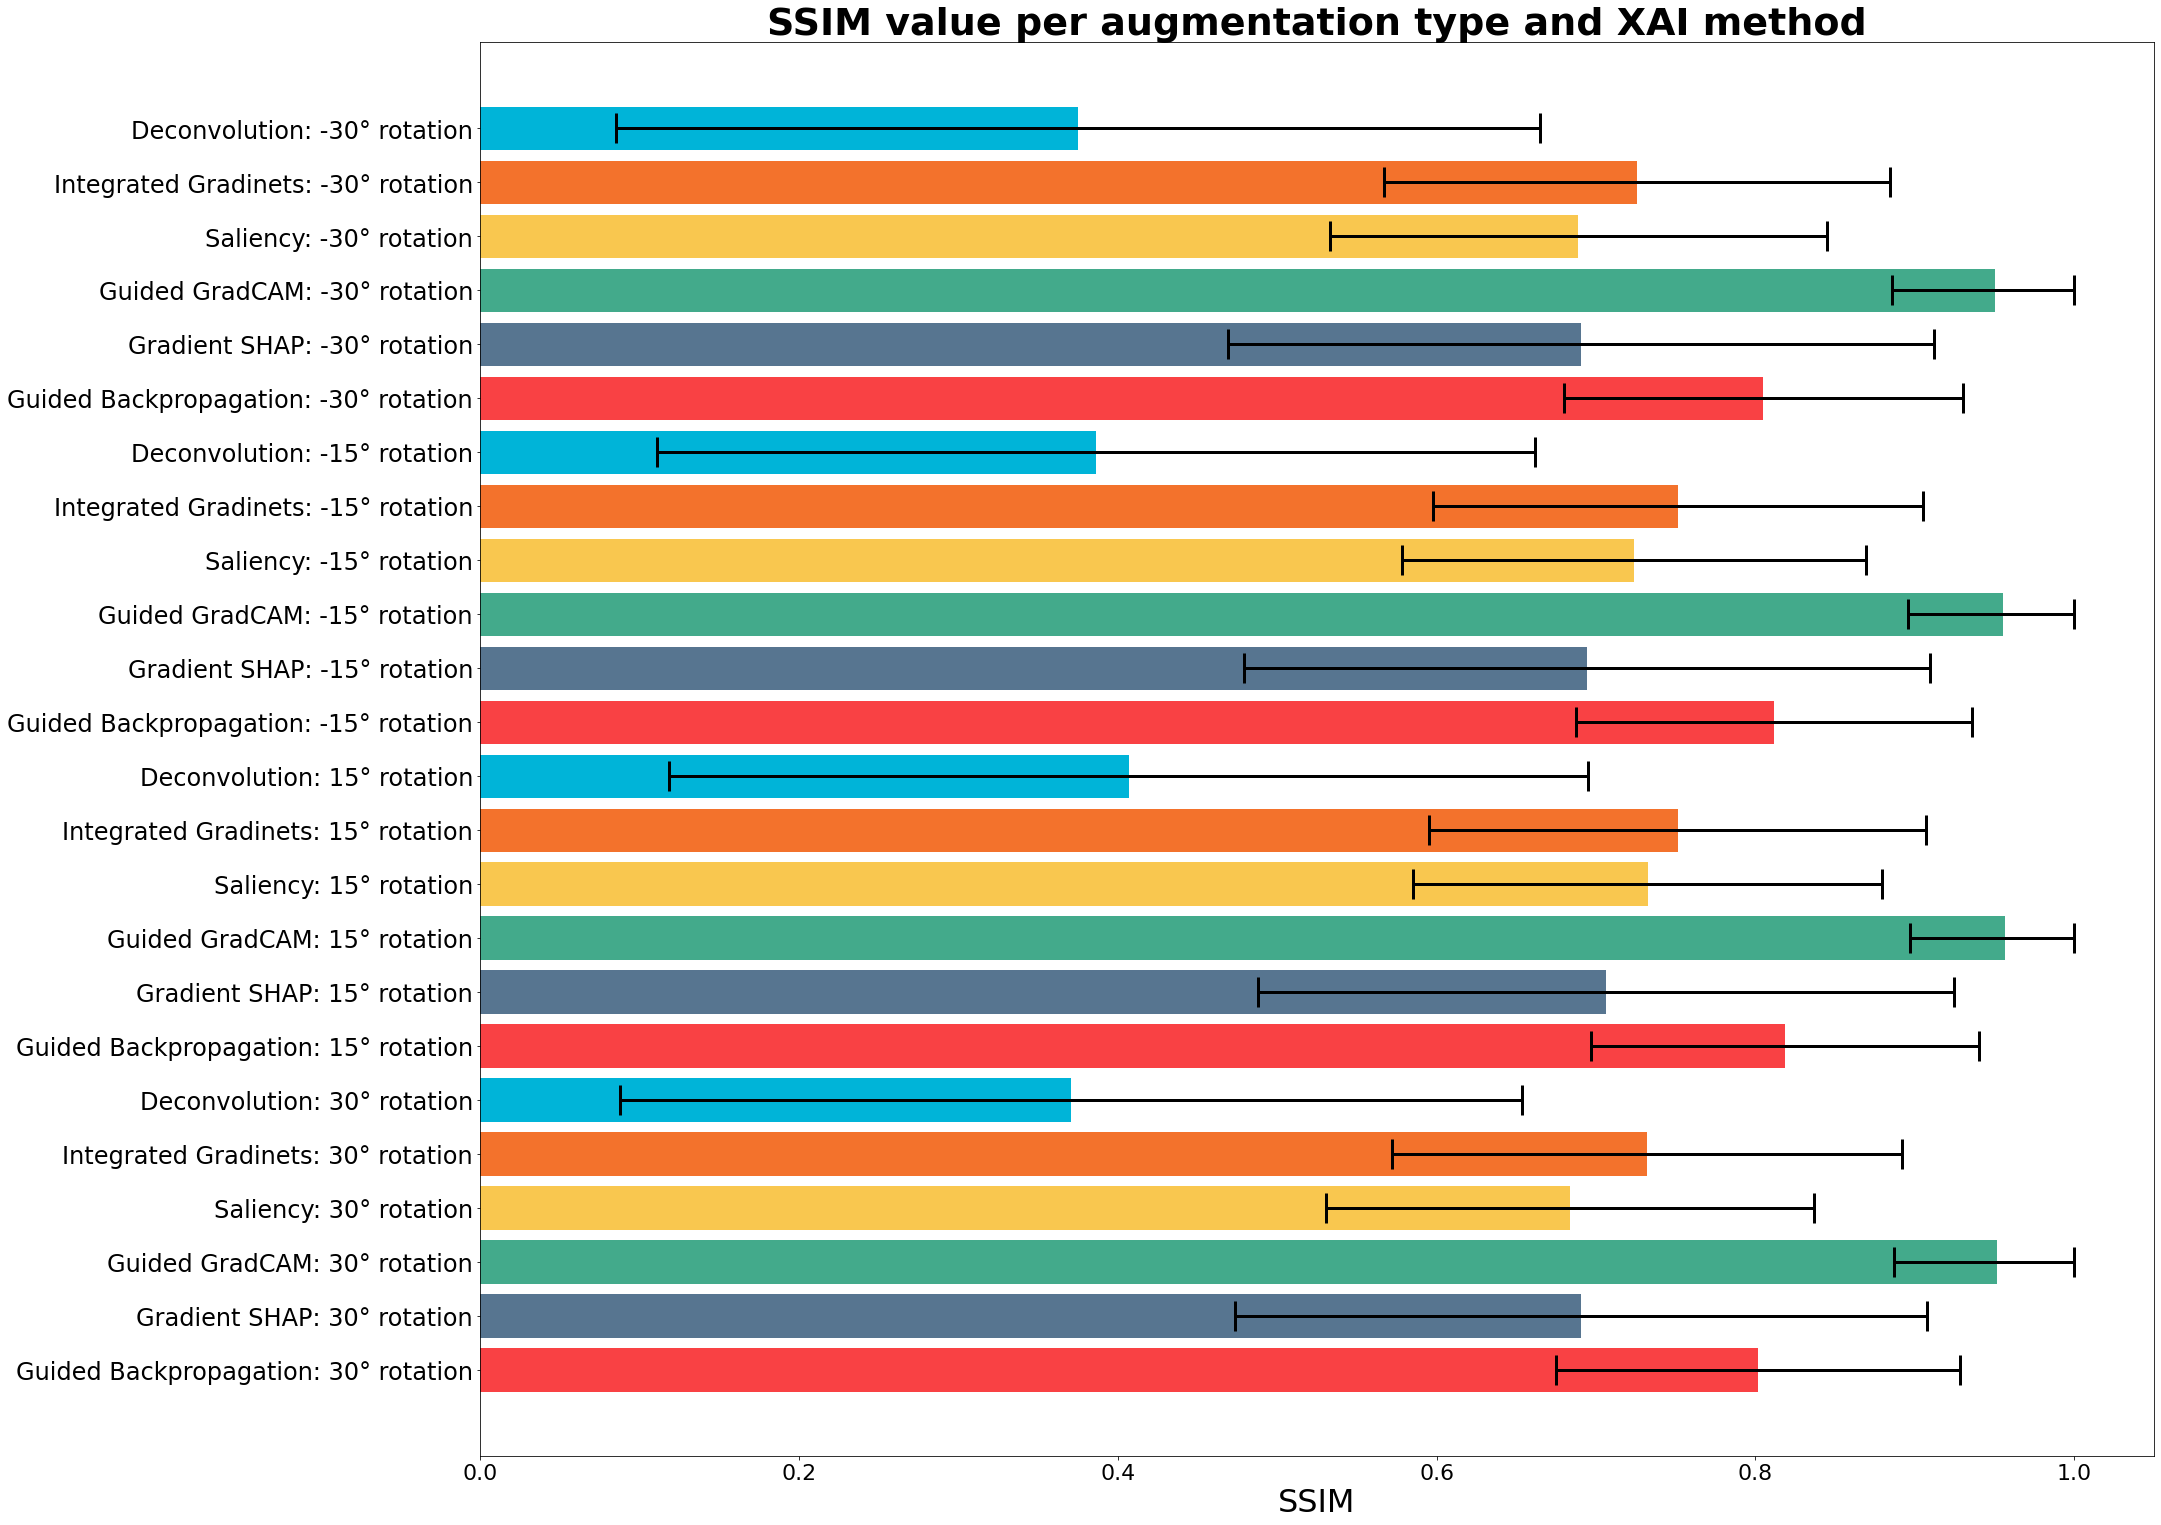

In [26]:
labels = []
means = []
stds = []

colors = [
    "#00b4d8",
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,26)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[0]
for aug_method in KEYS[aug_type][2:]:
    for method in METHODS.keys():
        means.append(RESULTS[aug_type][method][aug_method[0]]['mean'])
        stds.append([
            RESULTS[aug_type][method][aug_method[0]]['std'], 
            min(1.0 - RESULTS[aug_type][method][aug_method[0]]['mean'], RESULTS[aug_type][method][aug_method[0]]['std'])
        ])
        labels.append(LABEL_MAP[aug_method[0] + '-' + method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    capsize=15, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per augmentation type and XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/rotation-ssim.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/rotation-ssim.png', bbox_inches='tight')

all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

<Figure size 2160x1152 with 0 Axes>

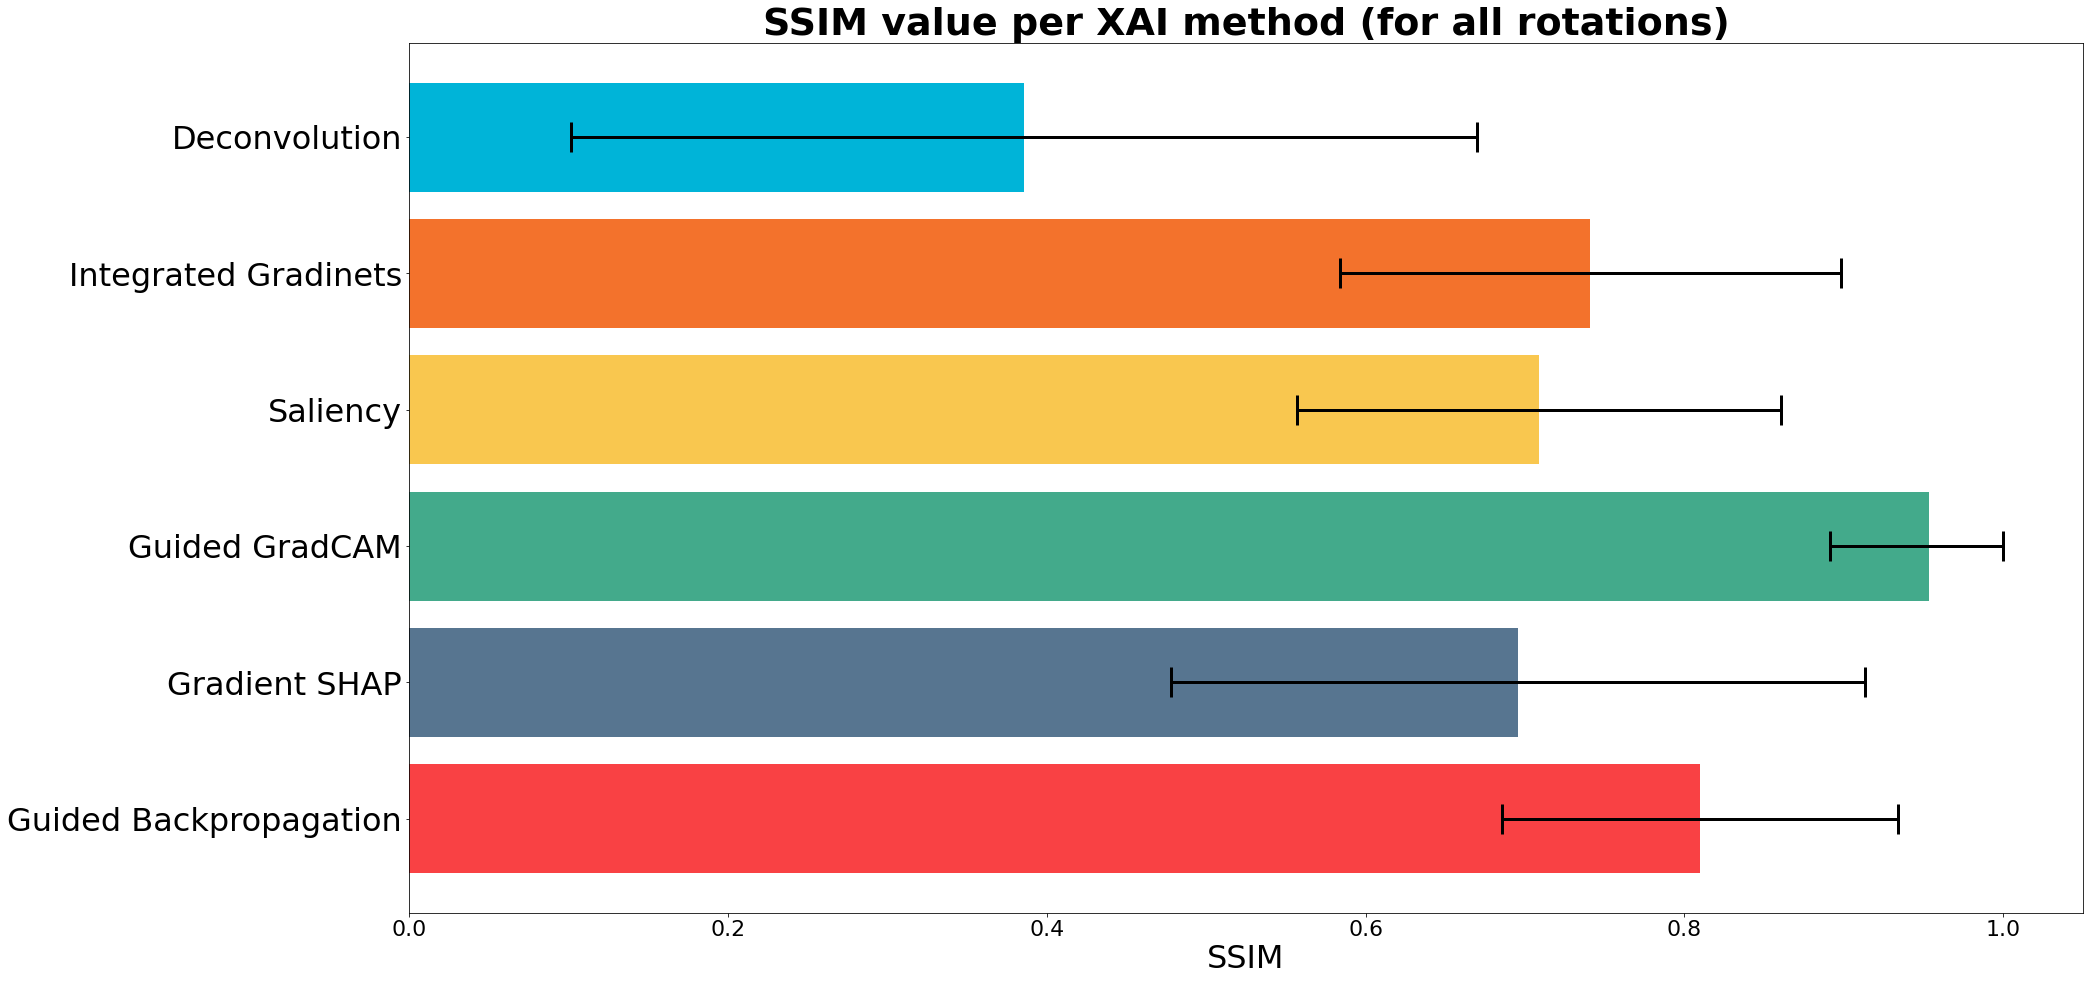

In [27]:
labels = []
means = []
stds = []

colors = [
    "#00b4d8",
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[0]
for method in METHODS.keys():
    means.append(RESULTS[aug_type][method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method (for all rotations)', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/rotation-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/rotation-all.png', bbox_inches='tight')
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + [ '(rotations)' + label for label in labels ]

<Figure size 2160x1872 with 0 Axes>

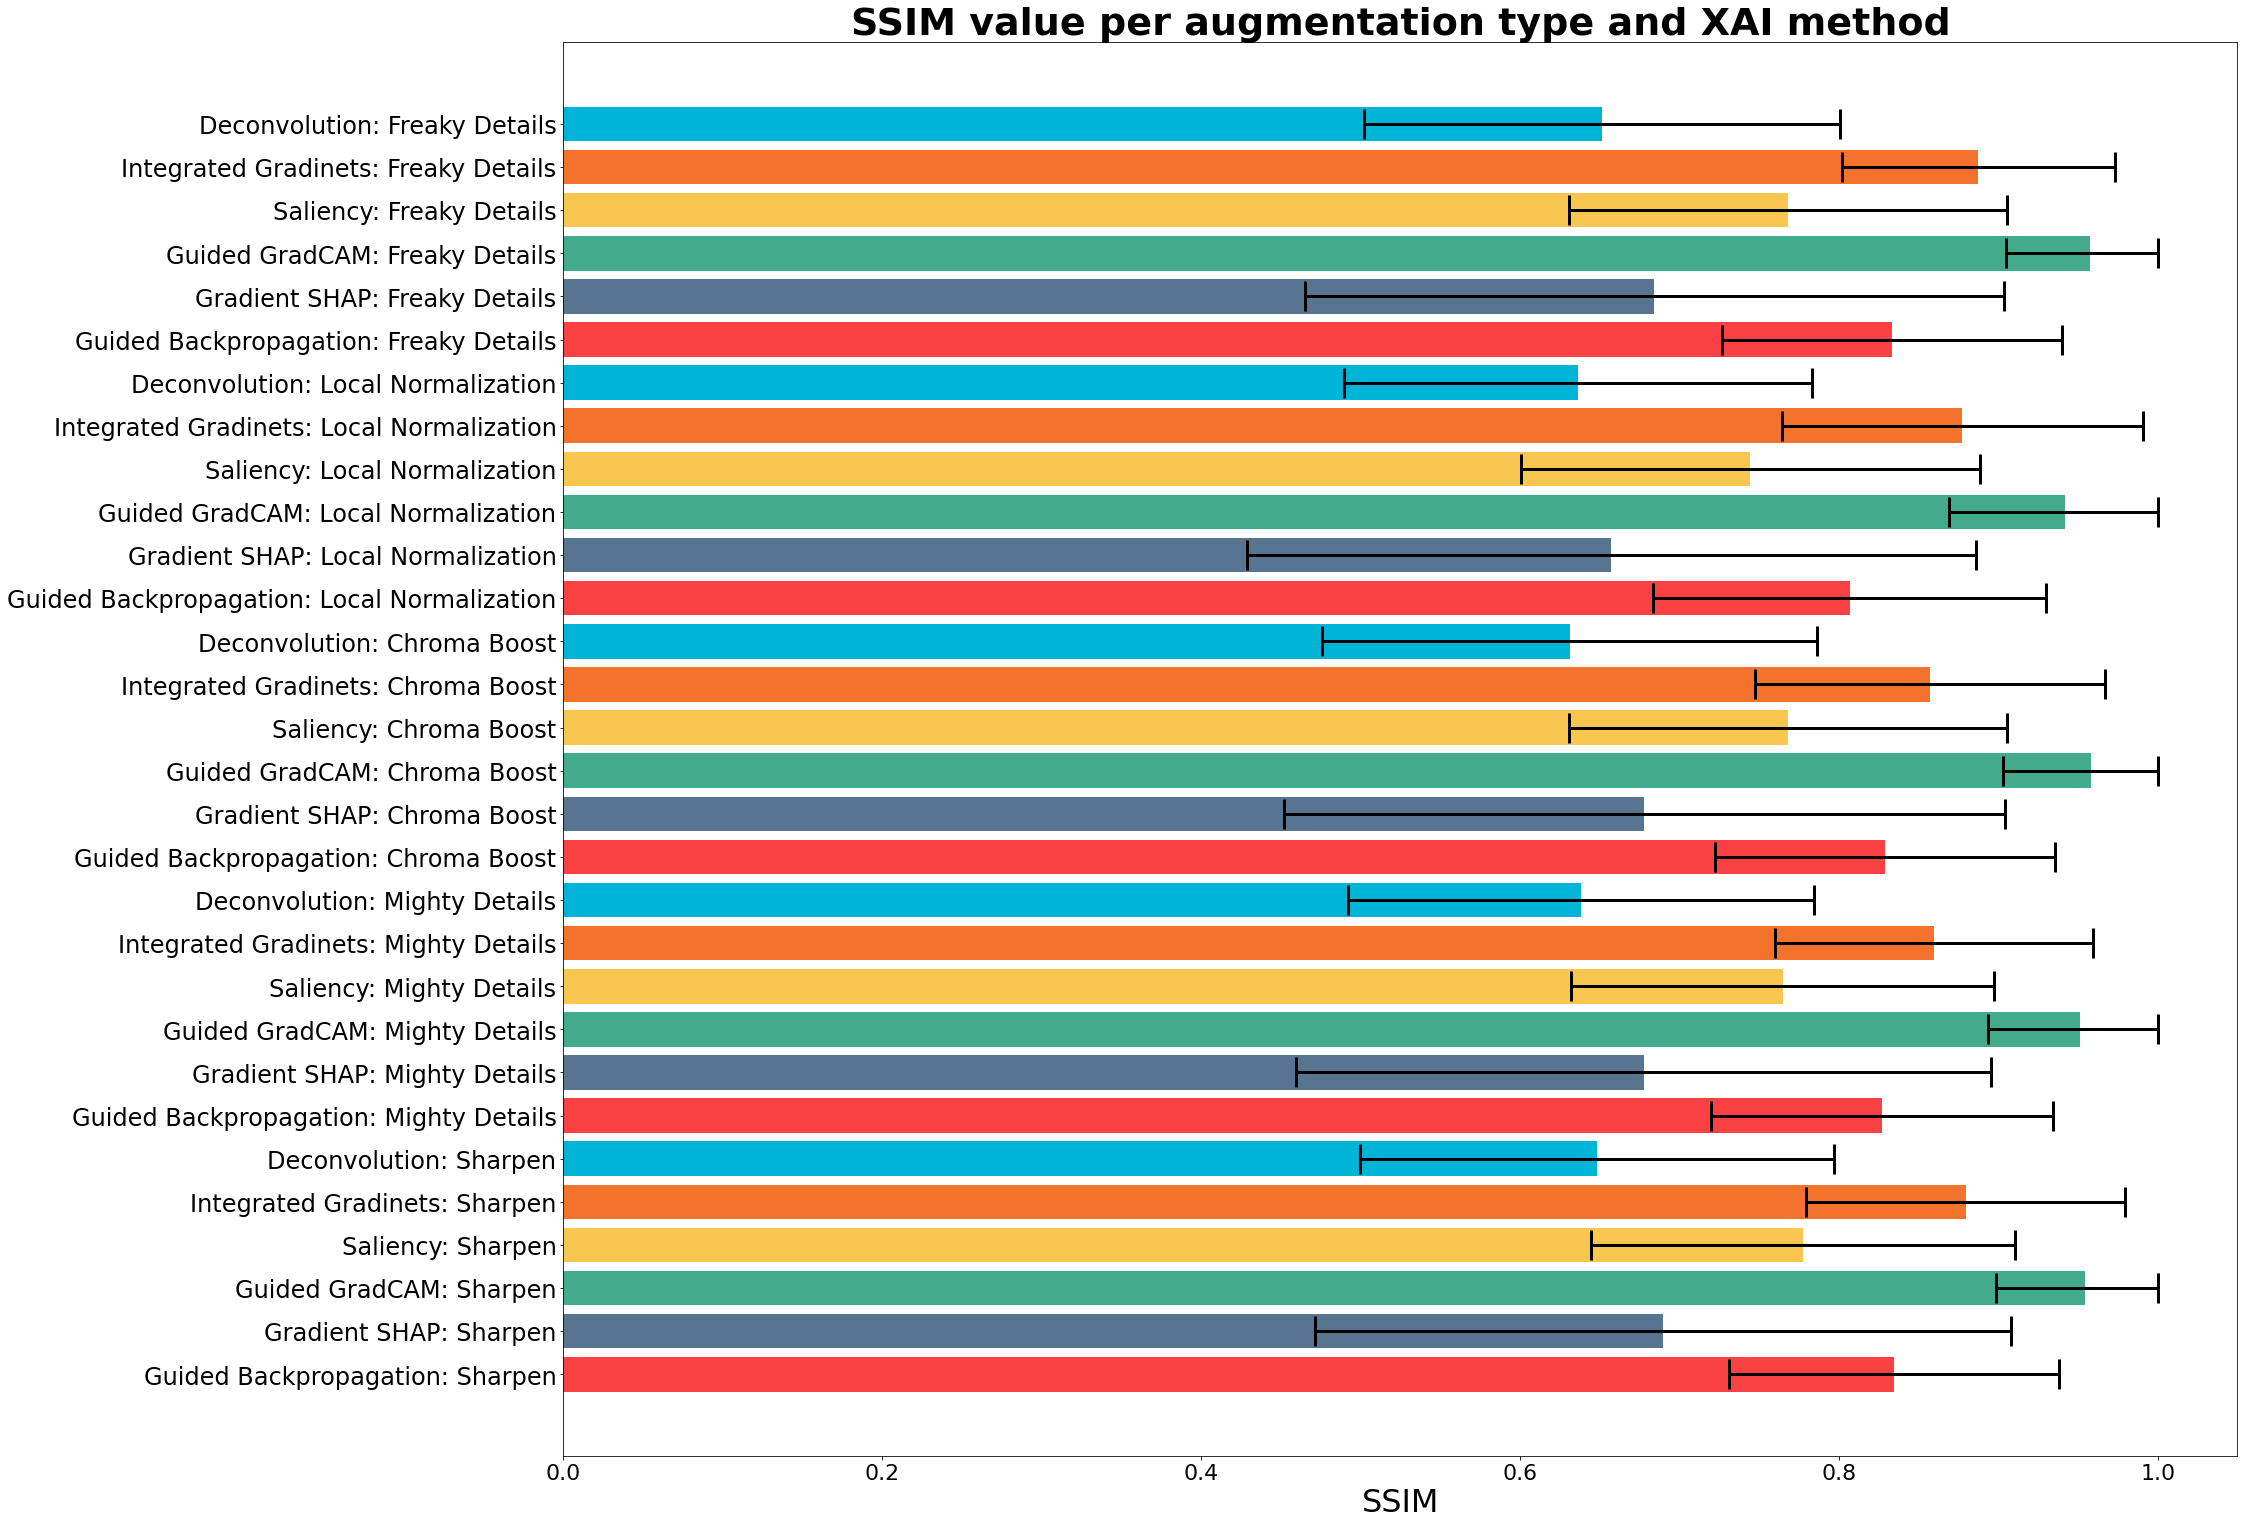

In [28]:
labels = []
means = []
stds = []

colors = [
    "#00b4d8",
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,26)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[1]
for aug_method in KEYS[aug_type][2:]:
    for method in METHODS.keys():
        means.append(RESULTS[aug_type][method][aug_method[0]]['mean'])
        stds.append([
            RESULTS[aug_type][method][aug_method[0]]['std'], 
            min(1.0 - RESULTS[aug_type][method][aug_method[0]]['mean'], RESULTS[aug_type][method][aug_method[0]]['std'])
        ])
        labels.append(LABEL_MAP[aug_method[0] + '-' + method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    capsize=15, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=24)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per augmentation type and XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/filters-ssim.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/filters-ssim.png', bbox_inches='tight')
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

<Figure size 2160x1152 with 0 Axes>

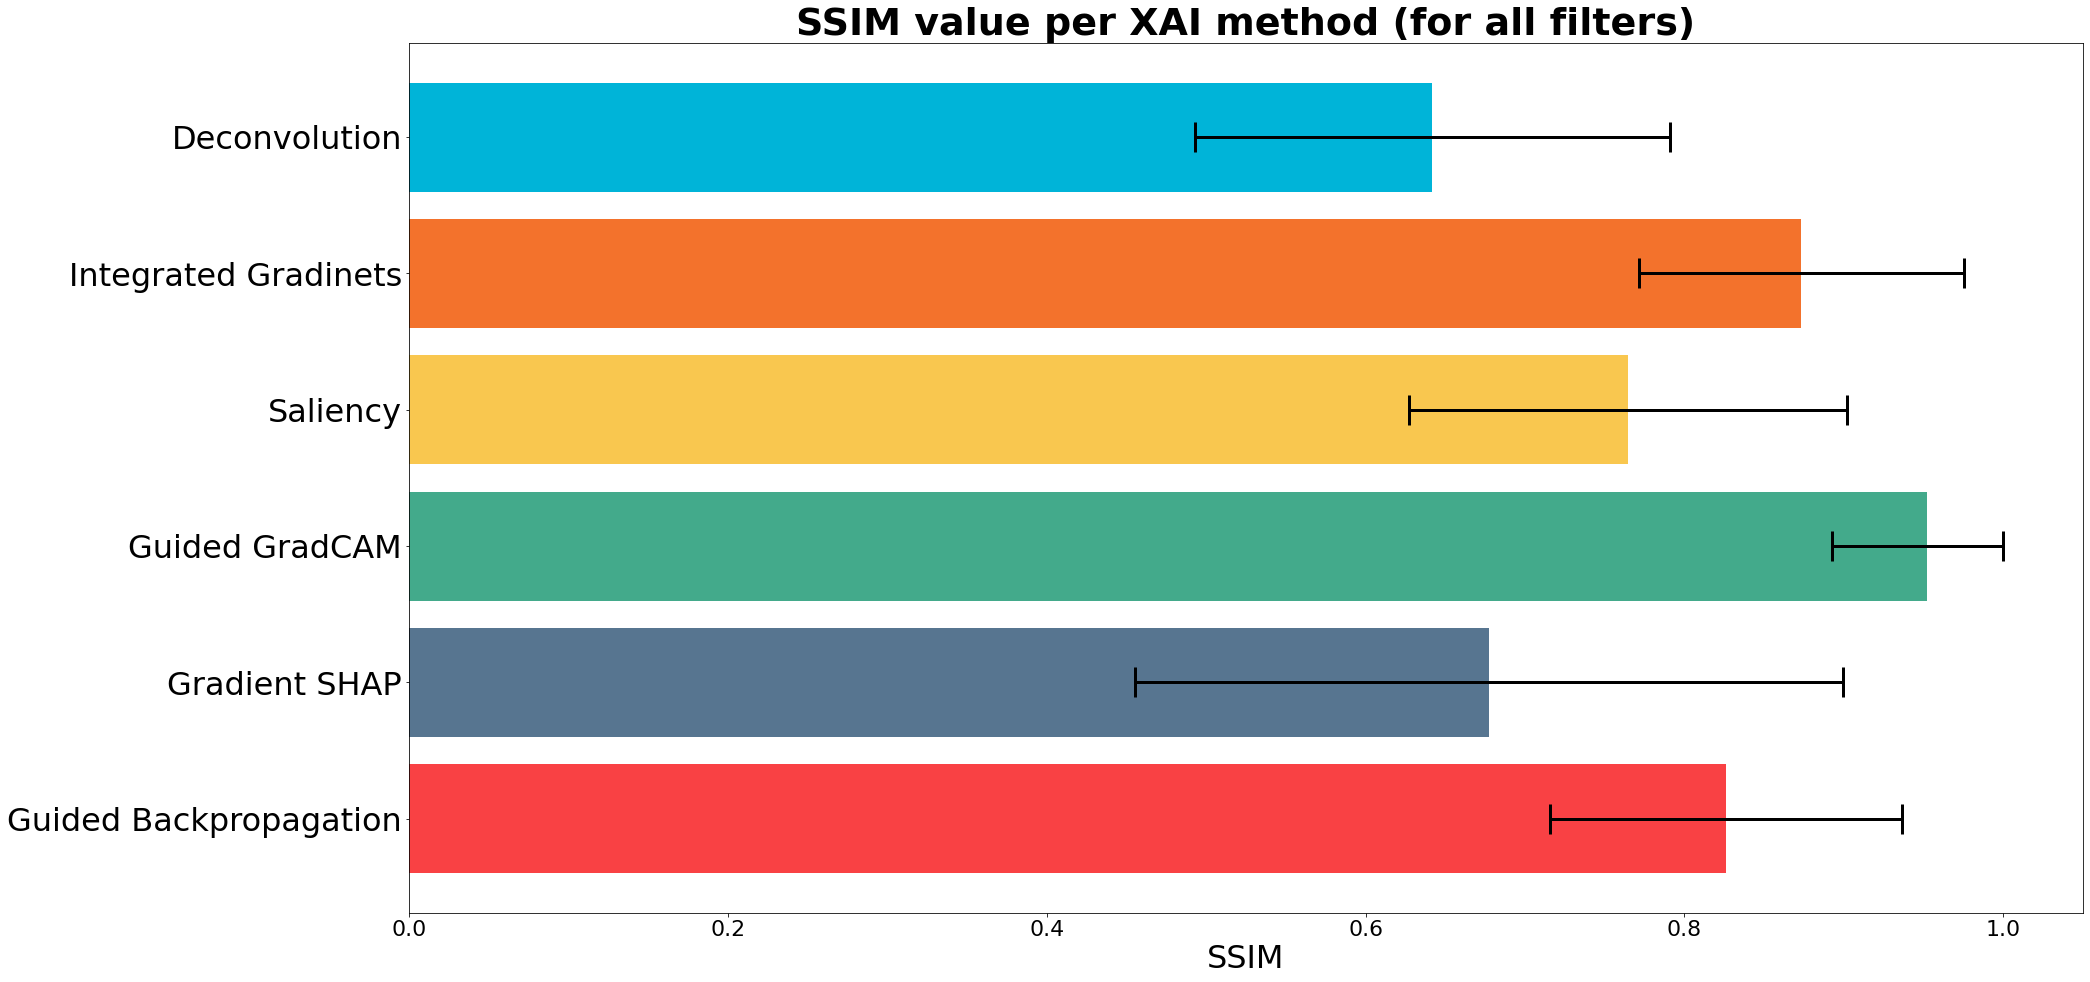

[0.6417809903841024, 0.8733429606375033, 0.7644743184875966, 0.9524200010456122, 0.6774220355028008, 0.8260946698692984]
[[0.14902452571346628, 0.14902452571346628], [0.10201667652849776, 0.10201667652849776], [0.13732856639573301, 0.13732856639573301], [0.059623478031892226, 0.0475799989543878], [0.2220059407368763, 0.2220059407368763], [0.11020755440129518, 0.11020755440129518]]


In [29]:
labels = []
means = []
stds = []

colors = [
    "#00b4d8",
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

aug_type = AUG_TYPES[1]
for method in METHODS.keys():
    means.append(RESULTS[aug_type][method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method (for all filters)', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/filters-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/filters-all.png', bbox_inches='tight')
print(means)
print(stds)
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + [ '(filters)' + label for label in labels ]

<Figure size 2160x1152 with 0 Axes>

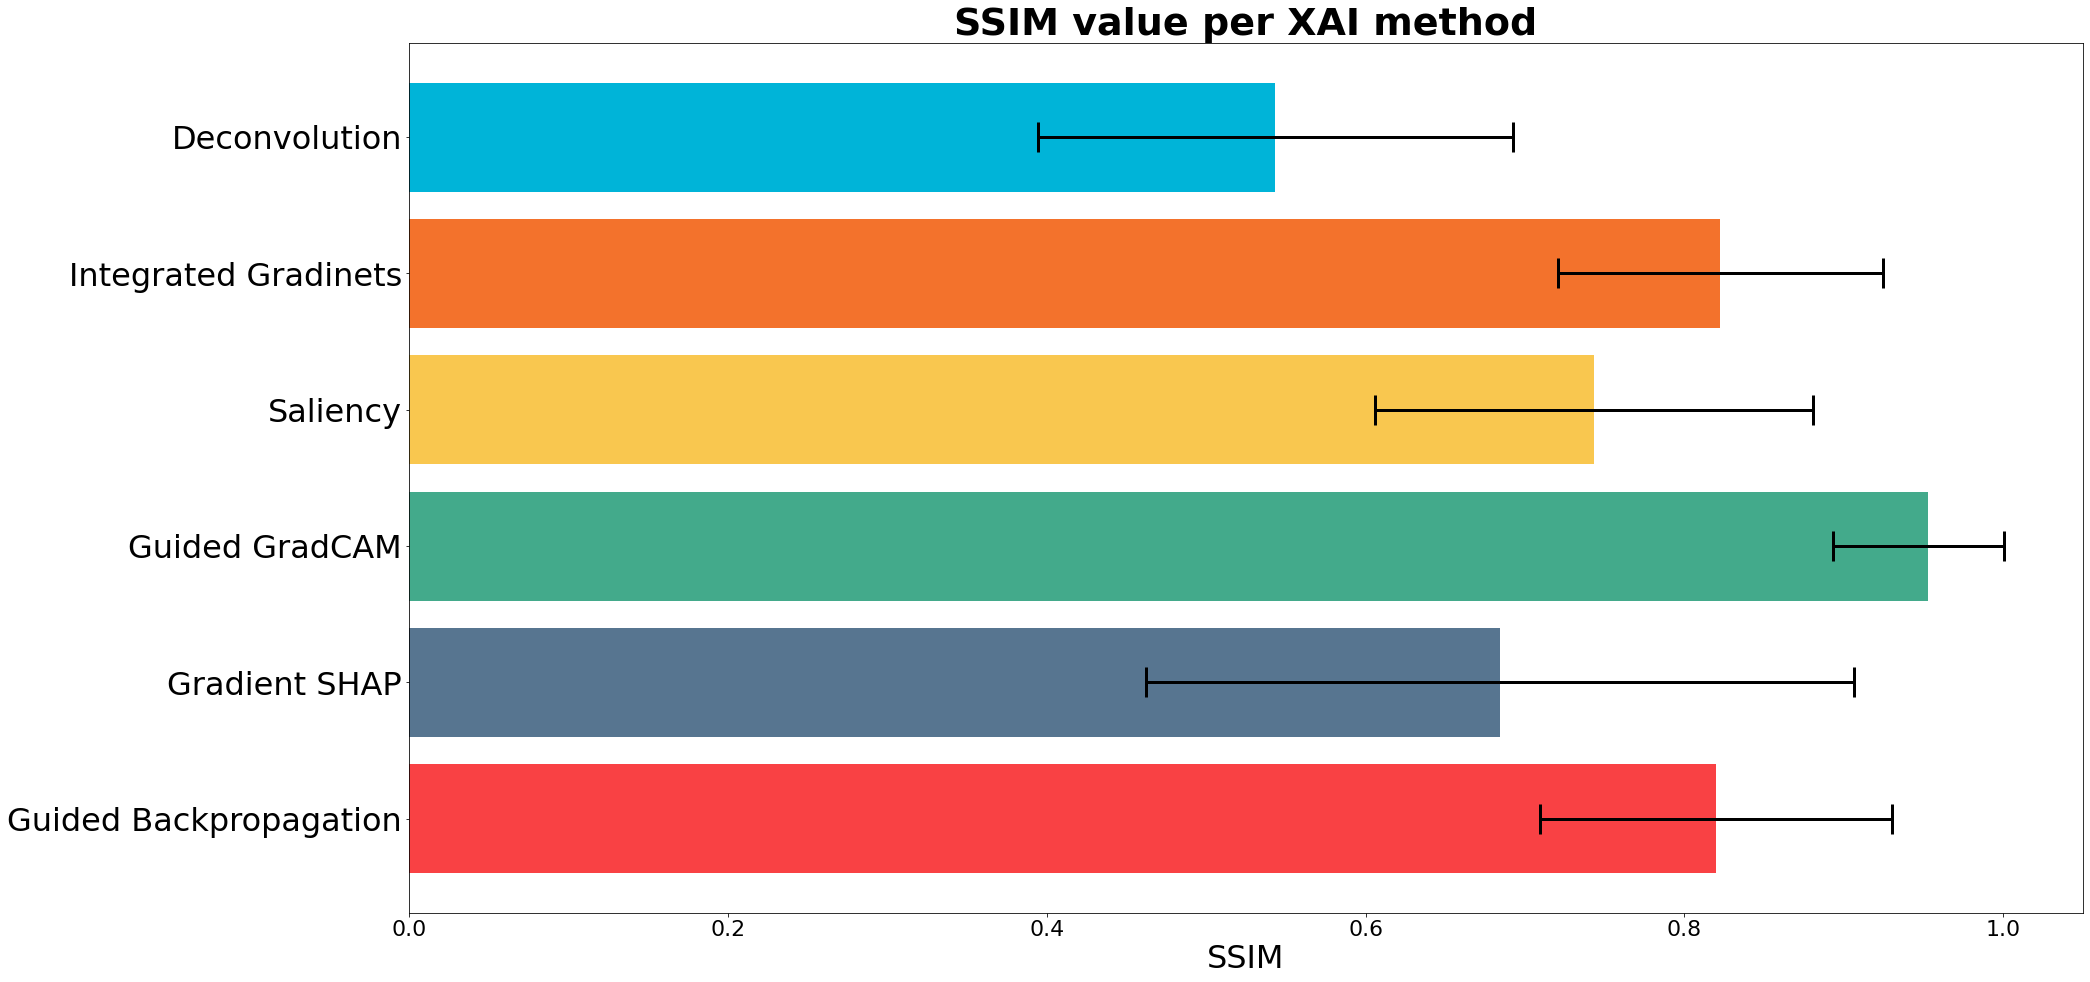

[0.5434607198965007, 0.8225348262099557, 0.7431165514079185, 0.9528777869508789, 0.68446498740759, 0.8197755782635124]
[[0.14902452571346628, 0.14902452571346628], [0.10201667652849776, 0.10201667652849776], [0.13732856639573301, 0.13732856639573301], [0.059623478031892226, 0.0475799989543878], [0.2220059407368763, 0.2220059407368763], [0.11020755440129518, 0.11020755440129518]]


In [30]:
labels = []
means = []
stds = []

colors = [
    "#00b4d8",
    "#F3722C",
    "#F9C74F",
    "#43AA8B",
    "#577590",
    "#F94144"
]

fig_size = (30,16)
plt.figure(figsize=fig_size) 
fig, ax = plt.subplots(figsize=fig_size)

for method in METHODS.keys():
    means.append(RESULTS[method]['mean'])
    stds.append([
        RESULTS[aug_type][method]['std'], 
        min(1.0 - RESULTS[aug_type][method]['mean'], RESULTS[aug_type][method]['std'])
    ])
    labels.append(LABEL_MAP[method])

ax.barh(
    np.arange(len(means)), 
    means, 
    xerr=np.array(stds).transpose(),
    align='center', 
    color=colors, 
    error_kw={'elinewidth':3, 'capsize': 15, 'capthick': 3}
)
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels, fontsize=32)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim((0, 1.05))
ax.set_xlabel('SSIM', fontsize=32)
ax.set_title('SSIM value per XAI method', fontsize=38,fontweight='bold')

plt.show()
fig.savefig(f'../augmentation-results/results-all.jpg', bbox_inches='tight')
fig.savefig(f'../augmentation-results/results-all.png', bbox_inches='tight')
print(means)
print(stds)
all_means = all_means + means
all_stds = all_stds + stds
all_labels = all_labels + labels

In [31]:
all_results = pd.DataFrame(
    {'label': all_labels,
     'mean': all_means,
     'std': all_stds
    }).set_index('label')

In [32]:
all_results

,mean,std
label,,
Deconvolution: -30° rotation,0.375110,"[0.28974427396986413, 0.28974427396986413]"
Integrated Gradinets: -30° rotation,0.725799,"[0.15871572297649156, 0.15871572297649156]"
Saliency: -30° rotation,0.688845,"[0.15590641480560422, 0.15590641480560422]"
Guided GradCAM: -30° rotation,0.950562,"[0.06509812368116011, 0.049437545695732776]"
Gradient SHAP: -30° rotation,0.690652,"[0.22116968570226797, 0.22116968570226797]"
...,...,...
Integrated Gradinets,0.822535,"[0.10201667652849776, 0.10201667652849776]"
Saliency,0.743117,"[0.13732856639573301, 0.13732856639573301]"
Guided GradCAM,0.952878,"[0.059623478031892226, 0.0475799989543878]"


In [33]:
print(all_results.to_latex())

\begin{tabular}{lrl}
\toprule
{} &      mean &                                           std \\
label                                       &           &                                               \\
\midrule
Deconvolution: -30° rotation                &  0.375110 &    [0.28974427396986413, 0.28974427396986413] \\
Integrated Gradinets: -30° rotation         &  0.725799 &    [0.15871572297649156, 0.15871572297649156] \\
Saliency: -30° rotation                     &  0.688845 &    [0.15590641480560422, 0.15590641480560422] \\
Guided GradCAM: -30° rotation               &  0.950562 &   [0.06509812368116011, 0.049437545695732776] \\
Gradient SHAP: -30° rotation                &  0.690652 &    [0.22116968570226797, 0.22116968570226797] \\
Guided Backpropagation: -30° rotation       &  0.805060 &    [0.12496695010347071, 0.12496695010347071] \\
Deconvolution: -15° rotation                &  0.386525 &      [0.2754155116181361, 0.2754155116181361] \\
Integrated Gradinets: -15° rotation    

In [34]:
## Search for all valid

In [35]:
PER_DATA_RES = { aug_type: { dataset_name: { method_name: {} for method_name in METHODS } for dataset_name in DATASETS.keys() } for aug_type in AUG_TYPES}
for model in MODELS.keys():
    for dataset in DATASETS.keys():
        for data_split in SPLIT_OPTIONS:
            for aug_type in AUG_TYPES:
                for method in METHODS.keys():
                    res_path = os.path.join(base_path, aug_type, dataset, f"{model}-{data_split}", method, f"{model}-{dataset}-{method}-ssim-with-range.csv")
                    method_df = pd.read_csv(res_path, delimiter=';')

                    PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"] = method_df

In [36]:
PER_DATA_RES['filters']['stanford-dogs']['gbp']['resnet18-100%']

,# none-ssim,none-score,"fx_freaky_details 2,10,1,11,0,32,0-ssim","fx_freaky_details 2,10,1,11,0,32,0-score","normalize_local 8,10-ssim","normalize_local 8,10-score","fx_boost_chroma 90,0,0-ssim","fx_boost_chroma 90,0,0-score","fx_mighty_details 25,1,25,1,11,0-ssim","fx_mighty_details 25,1,25,1,11,0-score",sharpen 300-ssim,sharpen 300-score
0,1.0,0.541908,0.989135,0.451088,0.980536,0.398562,0.987117,0.035457,0.987973,0.110162,0.988515,0.119699
1,1.0,0.346702,0.926736,0.177707,0.934811,0.001996,0.930199,0.032592,0.941669,0.015388,0.941114,0.023780
2,1.0,0.685653,0.876813,0.858952,0.843021,0.306747,0.869939,0.037431,0.872411,0.935710,0.878009,0.719043
3,1.0,0.991796,0.949273,0.994096,0.884608,0.948515,0.945607,0.030297,0.948903,0.996566,0.955307,0.991172
4,1.0,0.941225,0.930642,0.947322,0.929979,0.969386,0.927346,0.879372,0.909841,0.604100,0.940671,0.845317
5,1.0,0.814991,0.965397,0.864169,0.960110,0.725526,0.953733,0.628713,0.955968,0.743420,0.964585,0.827112
6,1.0,0.534494,0.959476,0.361003,0.952139,0.359465,0.958485,0.050531,0.940770,0.279225,0.947058,0.174373
7,1.0,0.996792,0.977954,0.999484,0.977997,0.998098,0.968721,0.188550,0.977125,0.943010,0.981093,0.987697
8,1.0,0.523249,0.956366,0.646521,0.920851,0.628999,0.973388,0.370230,0.954936,0.247551,0.969383,0.656381
9,1.0,0.995874,0.955441,0.996708,0.913497,0.947522,0.947416,0.637978,0.962580,0.992872,0.970079,0.999313


In [37]:
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in METHODS.keys():
                    for aug_method in KEYS[aug_type][2:]:
                        PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]] = PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]][(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[1]] - PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][KEYS[aug_type][1]]).abs() < threshold]

In [38]:
PER_DATA_RES['filters']['stanford-dogs']['gbp']['resnet18-100%']

,# none-ssim,none-score,"fx_freaky_details 2,10,1,11,0,32,0-ssim","fx_freaky_details 2,10,1,11,0,32,0-score","normalize_local 8,10-ssim","normalize_local 8,10-score","fx_boost_chroma 90,0,0-ssim","fx_boost_chroma 90,0,0-score","fx_mighty_details 25,1,25,1,11,0-ssim","fx_mighty_details 25,1,25,1,11,0-score",sharpen 300-ssim,sharpen 300-score
0,1.0,0.541908,NaN,0.451088,NaN,0.398562,NaN,0.035457,NaN,0.110162,NaN,0.119699
1,1.0,0.346702,NaN,0.177707,NaN,0.001996,NaN,0.032592,NaN,0.015388,NaN,0.023780
2,1.0,0.685653,NaN,0.858952,NaN,0.306747,NaN,0.037431,NaN,0.935710,0.878009,0.719043
3,1.0,0.991796,0.949273,0.994096,0.884608,0.948515,NaN,0.030297,0.948903,0.996566,0.955307,0.991172
4,1.0,0.941225,0.930642,0.947322,0.929979,0.969386,NaN,0.879372,NaN,0.604100,NaN,0.845317
5,1.0,0.814991,0.965397,0.864169,NaN,0.725526,NaN,0.628713,NaN,0.743420,0.964585,0.827112
6,1.0,0.534494,NaN,0.361003,NaN,0.359465,NaN,0.050531,NaN,0.279225,NaN,0.174373
7,1.0,0.996792,0.977954,0.999484,0.977997,0.998098,NaN,0.188550,NaN,0.943010,0.981093,0.987697
8,1.0,0.523249,NaN,0.646521,NaN,0.628999,NaN,0.370230,NaN,0.247551,NaN,0.656381
9,1.0,0.995874,0.955441,0.996708,0.913497,0.947522,NaN,0.637978,0.962580,0.992872,0.970079,0.999313


In [39]:
total_count = 0
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in METHODS.keys():
                    for aug_method in KEYS[aug_type][2:]:
                        total_count += PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]].isna().sum()

In [40]:
total_count

42048

In [41]:
total_items = 0
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in METHODS.keys():
                    for aug_method in KEYS[aug_type][2::2]:
                        total_items += PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"][aug_method[0]].count()

In [42]:
total_items

20292

In [43]:
for aug_type in ['rotation']:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in ['100%', '80%', '60%', '40%']:
                for method in METHODS.keys():
                    dir_path = f"../charts/aug_crop1/auto/{aug_type}/{dataset}/{method}/{model}/"
                    folder_to_copy_from = f"../experiments/{aug_type}/{dataset}/{model}-{data_split}/{method}/"
#                     print(dir_path)
#                     print(f"charts/aug_crop1/{aug_type}][{dataset}][{method}][{model}-{data_split}/")
#                     raise
                    
                    for index, row in PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna().iterrows():
#                         print(row, index)
                        if os.path.isdir(dir_path+str(index)):
                            continue
                        Path(dir_path+str(index)).mkdir(parents=True, exist_ok=True)
                        for file in glob.glob(f"{folder_to_copy_from}/{index}-*.png"):
                            new_name = os.path.basename(file)[os.path.basename(file).index('rotation'):]
                            copyfile(file, f"{dir_path}{index}/{new_name}")
#                             print(os.path.basename(file)[os.path.basename(file).index('rotation'):])
#                     raise
#                     print(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna().iloc[:, 0])
#                     print('-------------------------------------------------')
#                     print('-------------------------------------------------')
#                     print('-------------------------------------------------')

In [44]:
def findnth(string, substring, n):
    parts = string.split(substring, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(string) - len(parts[-1]) - len(substring)

In [45]:
for aug_type in ['filters']:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in ['100%', '80%', '60%', '40%']:
                for method in METHODS.keys():
                    dir_path = f"../charts/aug_crop1/auto/{aug_type}/{dataset}/{method}/{model}/"
                    folder_to_copy_from = f"../experiments/{aug_type}/{dataset}/{model}-{data_split}/{method}/"
#                     print(dir_path)
#                     print(f"charts/aug_crop1/{aug_type}][{dataset}][{method}][{model}-{data_split}/")
#                     raise
                    
                    for index, row in PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna().iterrows():
#                         print(row, index)
                        if os.path.isdir(dir_path+str(index)):
                            continue
                        Path(dir_path+str(index)).mkdir(parents=True, exist_ok=True)
                        for file in glob.glob(f"{folder_to_copy_from}/{index}-*.png"):
                            name_start_index = findnth(os.path.basename(file), '-', 2)
                            new_name = os.path.basename(file)[name_start_index+1:]
                            copyfile(file, f"{dir_path}{index}/{new_name}")
#                             print(os.path.basename(file)[os.path.basename(file).index('rotation'):])
#                     raise
#                     print(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna().iloc[:, 0])
#                     print('-------------------------------------------------')
#                     print('-------------------------------------------------')
#                     print('-------------------------------------------------')

In [29]:
for aug_type in AUG_TYPES:
    for model in MODELS.keys():
        for dataset in DATASETS.keys():
            for data_split in SPLIT_OPTIONS:
                for method in['ig']:
                    print(f"{aug_type}][{dataset}][{method}][{model}-{data_split}")
                    print(PER_DATA_RES[aug_type][dataset][method][f"{model}-{data_split}"].dropna().iloc[:, 0])
                    print('-------------------------------------------------')
                    print('-------------------------------------------------')
                    print('-------------------------------------------------')

rotation][edible-plants][ig][resnet18-100%
0     1.0
2     1.0
4     1.0
11    1.0
13    1.0
Name: # 0-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
rotation][edible-plants][ig][resnet18-80%
0     1.0
4     1.0
13    1.0
Name: # 0-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
rotation][edible-plants][ig][resnet18-60%
4     1.0
11    1.0
Name: # 0-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
rotation][edible-plants][ig][resnet18-40%
4     1.0
13    1.0
Name: # 0-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------

Name: # none-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
filters][edible-plants][ig][densenet-20%
0    1.0
3    1.0
Name: # none-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
filters][food101][ig][densenet-100%
1     1.0
3     1.0
8     1.0
10    1.0
13    1.0
14    1.0
17    1.0
Name: # none-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
filters][food101][ig][densenet-80%
8     1.0
10    1.0
14    1.0
15    1.0
17    1.0
Name: # none-ssim, dtype: float64
-------------------------------------------------
-------------------------------------------------
-------------------------------------------------
filters][food1